In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score

In [2]:
%matplotlib inline

# `Ridge Regression`

### ------------------------------------------------------------------------------------------------

# Overview 

 **Goal**: predict the behavior of a continuous _endogenous_ variable given its corresponding _exogenous_ variables, under the constraint that we are penalizing based on coefficient magnitudes when solving for said coefficients. This setup allows for models that are less prone to over-fitting than simple OLS models are.
 
 **Model**: $y = X{\beta} + {\epsilon}$

**Terms**:
- $y$: vector of endogenous values
- $X$: matrix of exogenous values
- $\beta$: vector of coefficients for exogenous variables
- $\epsilon$: a representation of the random errors or fluctuations around the predicted line or plane

**Functionality**:
- $y$ is the result of taking the matrix product of $\beta$ and $X$
- i.e. each row in $y$ is the sum of the products, for that row, of each value of $X$ with its corresponding $\beta$

**Basic example**:
- *endogenous*: price of an apartment
- *exogenous*: square footage (1), number of rooms (2)
- $y = \beta_{0} + \beta_{1} * X_{1} + \beta_{2} * X_{2} + \epsilon$
- i.e. $constant + coefficient_{1} * area + coefficient_{2} * rooms$

### ------------------------------------------------------------------------------------------------

# Tikhonov regularization

$\displaystyle \min _{\beta }\,(\mathbf {y} -\mathbf {X} \beta )^{\mathsf {T}}(\mathbf {y} -\mathbf {X} \beta )+\lambda (\beta ^{\mathsf {T}}\beta -c)$

$\displaystyle {\hat {\beta }}_{R}=(\mathbf {X} ^{\mathsf {T}}\mathbf {X} +\lambda \mathbf {I} )^{-1}\mathbf {X} ^{\mathsf {T}}\mathbf {y}$

### ------------------------------------------------------------------------------------------------

# Parameter Estimation - OLS

**Goal**: given $X$ and $y$, find $\beta$

**Method**: there exist many ways to reach our goal - we will start with Ordinary Least Squares (OLS)

(notes written with support from [Wikipedia](https://en.wikipedia.org/wiki/Ordinary_least_squares) and [ESL](http://web.stanford.edu/~hastie/ElemStatLearn/))

### Background

- to measure the distance between a response and a predicted response, one can take the difference between the two values
- this would be written as, for the $i^{th}$ data point, $y_{i} - {X_{i}}\beta$ (note that $X_{i}$ is a row of $X$), and is referred to as the _residual_ for this data point

### Overall model fit

- summing the squares of all residuals provides a measure of overall model fit
- sum of squared residuals: $\sum_{i=1}^{n}(y_{i} - \sum_{j=1}^{p}{X_{i, j}\beta_{j})}^{2} = {(y-X\beta)}^{T}(y-X\beta)$

### Estimate Beta

- if we find the values of $\beta$ that minimize the sum of the squared residuals, we have found the model coefficients that provide the best fit
- to find the values of $\beta$ that minimize ${(y-X\beta)}^{T}(y-X\beta)$ we need to first differentiate with respect to $\beta$, yielding a first derivative $-2X^{T}(y - X\beta)$
- if we set that first derivate equal to 0, $X^{T}(y - X\beta) = 0$, we can, making some assumptions, solve to:

$$\hat\beta = (X^{T}X)^{-1}X^{T}y$$

- see more on the derivation of OLS regression [here](https://are.berkeley.edu/courses/EEP118/current/derive_ols.pdf)

### Evaluation

- a commonly used metric for fit assessment is that of $R^{2}$
- this is the ratio of the variance of $\hat{y}$ around the mean of $y$, $\bar{y}$, to the variance of $y$, i.e. the ratio of "explained" to "total" variance of $y$
- which is written as $\large\frac{\sum(\hat{y} - \bar{y})^{2}}{\sum(y - \bar{y})^{2}}$
- useful use of this metric requires the model to include a constant, or $\beta_{0}$, term, in which case 0 < $R^{2}$ < 1, with closer to 1 being better

### ------------------------------------------------------------------------------------------------

# Implementation

In [3]:
class RidgeRegressor:
    """Ridge Regression class, built for NumPy arrays. Fits using lin alg.
    Always supplies a constant coefficient.
    """
    
    def __init__(self, lambda_=1):
        self.beta = None
        self.lambda_ = lambda_
    
    @staticmethod
    def get_X_with_coeff_col(X):
        for_coeff = np.ones((X.shape[0], 1))
        return np.hstack((X, for_coeff))
    
    def fit(self, X, y):
        X = self.get_X_with_coeff_col(X)
        self.beta = np.linalg.inv(X.T.dot(X) + self.lambda_ * np.identity(X.shape[1])).dot(X.T).dot(y)
        return self

    def predict(self, X):
        if self.beta is None:
            return None
        
        X = self.get_X_with_coeff_col(X)
        return  X.dot(self.beta)
    
    def r_sqrd(self, y, y_hat):
        if self.beta is None:
            return None
            
        y_bar = np.mean(y)
        explained = np.sum(np.power(y_hat - y_bar, 2))
        total = np.sum(np.power(y - y_bar, 2))

        return explained / total

### ------------------------------------------------------------------------------------------------

# Testing
- Insurance data, which can be found [here](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv)
- Independent variables: `age`, `sex`, `bmi`, `children`, `smoker`, `region`
- Dependent variables: `charges`

### Get Data

In [4]:
url ="https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"

In [5]:
insurance_data = pd.read_csv(url)

In [6]:
insurance_data.shape

(1338, 7)

In [7]:
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Quality check

In [8]:
insurance_data.duplicated().sum()

1

In [9]:
insurance_data = insurance_data.drop_duplicates()

In [10]:
insurance_data.duplicated().sum()

0

In [11]:
insurance_data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### EDA

(very quick)

In [12]:
insurance_data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

#### Numeric features

In [13]:
insurance_data[["charges", "bmi", "age", "children"]].corr()

,charges,bmi,age,children
charges,1.000000,0.198401,0.298308,0.067389
bmi,0.198401,1.000000,0.109344,0.012755
age,0.298308,0.109344,1.000000,0.041536
children,0.067389,0.012755,0.041536,1.000000


**Notes**

- we see predictive potential between these features and our target, but we also see correlation between these two features themselves

### Modeling data

Get target:

In [14]:
y = insurance_data.charges

Randomly split data:

In [15]:
slice_a, slice_b = train_test_split(y.index, test_size=.5, random_state=5)

One-feature setup:

In [16]:
x = insurance_data.age

Three-feature setup:

In [17]:
X = insurance_data[["age", "bmi","children"]]

### Predict: `LinearRegression`, one feature

In [18]:
reg = LinearRegression()

#### Fit to `slice_a`

In [19]:
reg = reg.fit(x.loc[slice_a].values.reshape(-1, 1), y.loc[slice_a])

In [20]:
y_pred = reg.predict(x.loc[slice_b].values.reshape(-1, 1))

In [21]:
r2_a = r2_score(y.loc[slice_b], y_pred)

In [22]:
r2_a

0.08074719940343589

#### Fit to `slice_b`

In [23]:
reg = reg.fit(x.loc[slice_b].values.reshape(-1, 1), y.loc[slice_b])

In [24]:
y_pred = reg.predict(x.loc[slice_a].values.reshape(-1, 1))

In [25]:
r2_b = r2_score(y.loc[slice_a], y_pred)

#### Compare 

In [26]:
r2_b / r2_a

1.0543408511061463

**Notes**

- we don't see much of a delta when switching out which piece of the data we're training on and which we're testing on
- we only did this once (many trials would be better) but this could be an indicator of a pretty consistent relationship between `age` and `charges`

### Predict: `LinearRegression`, three features

In [27]:
y = insurance_data.charges

In [28]:
reg = LinearRegression()

In [29]:
reg = reg.fit(X.loc[slice_a], y.loc[slice_a])

In [30]:
y_pred = reg.predict(X.loc[slice_b])

In [31]:
r2_a = r2_score(y.loc[slice_b], y_pred)

In [32]:
r2_a

0.09622259960930013

In [33]:
reg = reg.fit(X.loc[slice_b], y.loc[slice_b])

In [34]:
y_pred = reg.predict(X.loc[slice_a])

In [35]:
r2_b = r2_score(y.loc[slice_a], y_pred)

In [36]:
r2_b

0.12246861113996532

In [37]:
abs(r2_b / r2_a - 1)

0.27276348422547136

**Notes**

- we see a pretty big delta when switching out which piece of the data we're training on and which we're testing on!
- as we've increased the number of features, we're seeing more _variance_ in our model's performance

### Predict: `Ridge`, three features

In [38]:
reg = RidgeRegressor(lambda_=100)

In [39]:
reg = reg.fit(X.loc[slice_a], y.loc[slice_a])

In [40]:
y_pred = reg.predict(X.loc[slice_b])

In [41]:
r2_a = r2_score(y.loc[slice_b], y_pred)

In [42]:
r2_a

0.10068833196331772

In [43]:
reg = reg.fit(X.loc[slice_b], y.loc[slice_b])

In [44]:
y_pred = reg.predict(X.loc[slice_a])

In [45]:
r2_b = r2_score(y.loc[slice_a], y_pred)

In [46]:
r2_b

0.11259368111164914

In [47]:
abs(r2_b / r2_a - 1)

0.11823961045127573

**Notes**
- this is much lower than what we saw for `LinearRegression`

In [48]:
reg = RidgeRegressor(lambda_=100000)

In [49]:
reg = reg.fit(X.loc[slice_a], y.loc[slice_a])

In [50]:
y_pred = reg.predict(X.loc[slice_b])

In [51]:
r2_a = r2_score(y.loc[slice_b], y_pred)

In [52]:
r2_a

0.10219223650058129

In [53]:
reg = reg.fit(X.loc[slice_b], y.loc[slice_b])

In [54]:
y_pred = reg.predict(X.loc[slice_a])

In [55]:
r2_b = r2_score(y.loc[slice_a], y_pred)

In [56]:
r2_b

0.09650818623067337

In [57]:
abs(r2_b / r2_a - 1)

0.05562115542774715

**Notes**
- and, this is even lower than our previous trial

### Many trials

- let's try to turn our quick checks from above into a more robust examination
- we'll run repeated trials across different values of `lambda_`

In [58]:
def get_performance_ratio(model_cls, X, y, slice_a, slice_b, **model_kwargs):
    model_obj = model_cls(**model_kwargs)

    model_obj = model_obj.fit(X.loc[slice_a], y.loc[slice_a])
    y_pred = model_obj.predict(X.loc[slice_b])
    r2_a = r2_score(y.loc[slice_b], y_pred)

    model_obj = model_obj.fit(X.loc[slice_b], y.loc[slice_b])
    y_pred = model_obj.predict(X.loc[slice_a])
    r2_b = r2_score(y.loc[slice_a], y_pred)

    return abs(r2_b / r2_a - 1)

In [59]:
def run_trial(
            X, y,
            model_classes=(LinearRegression, RidgeRegressor),
            model_cls_kwargs=None
    ):
    slice_a, slice_b = train_test_split(y.index, test_size=.5)
    
    if model_cls_kwargs is None:
        model_cls_kwargs = {}
    
    results = {}
    for model_cls in model_classes:
        model_name = model_cls.__name__
        model_kwargs = model_cls_kwargs.get(model_name, {})
        
        performance = get_performance_ratio(model_cls, X, y, slice_a, slice_b, **model_kwargs)
        results[model_name] = performance
    
    return results

Let's test out these functions:

In [60]:
run_trial(X, y)

{'LinearRegression': 0.40223408352899637,
 'RidgeRegressor': 0.39456118604188606}

In [61]:
model_cls_kwargs = {"RidgeRegressor": {"lambda_": 100}}

In [62]:
run_trial(X, y, model_cls_kwargs=model_cls_kwargs)

{'LinearRegression': 0.34648456232320435, 'RidgeRegressor': 0.314966191179883}

Looking good! Now, we'll run 100 trials each for many different values of `lambda_` (incrementing in powers of 10):

In [63]:
results = []

# run each `lambda_` value through 100 trials
for i in range(100):
    
    # try 10**-5 (close to 0 / LinearRegression) through 10**5 (lots of regularization)
    lambda_vals = [10**n for n in range(-5, 6, 1)]
    for lambda_ in lambda_vals:
        
        # programmatically generate the `model_cls_kwargs` with new `lambda_` value
        model_cls_kwargs = {"RidgeRegressor": {"lambda_": lambda_}}
        
        # get performance
        performance = run_trial(X, y, model_cls_kwargs=model_cls_kwargs)
        
        # retain trial
        trial = {"trial_num": i, "lambda_": lambda_, "performance": performance}
        results.append(trial)

Quick check on results:

In [64]:
len(results)

1100

In [65]:
results[0]

{'trial_num': 0,
 'lambda_': 1e-05,
 'performance': {'LinearRegression': 0.36375985350944484,
  'RidgeRegressor': 0.36375982072250235}}

Wrangle into a `pd.DataFrame`:

In [66]:
pd.DataFrame(results).head()

,trial_num,lambda_,performance
0,0,0.00001,"{'LinearRegression': 0.36375985350944484, 'Rid..."
1,0,0.00010,"{'LinearRegression': 0.18436005933894384, 'Rid..."
2,0,0.00100,"{'LinearRegression': 0.8187806484987152, 'Ridg..."
3,0,0.01000,"{'LinearRegression': 0.30418457256110965, 'Rid..."
4,0,0.10000,"{'LinearRegression': 0.00010446653596729583, '..."


In [67]:
df = pd.DataFrame(results)

In [68]:
df.performance.apply(pd.Series).head()

,LinearRegression,RidgeRegressor
0,0.363760,0.363760
1,0.184360,0.184361
2,0.818781,0.818771
3,0.304185,0.304147
4,0.000104,0.000584


In [69]:
df = df.drop("performance", axis=1).join(df.performance.apply(pd.Series))

In [70]:
df.head()

,trial_num,lambda_,LinearRegression,RidgeRegressor
0,0,0.00001,0.363760,0.363760
1,0,0.00010,0.184360,0.184361
2,0,0.00100,0.818781,0.818771
3,0,0.01000,0.304185,0.304147
4,0,0.10000,0.000104,0.000584


In [71]:
df = df.drop("trial_num", axis=1)

In [72]:
df.shape

(1100, 3)

### Trial analysis

In [73]:
df[["LinearRegression", "RidgeRegressor"]].describe()

,LinearRegression,RidgeRegressor
count,1100.000000,1100.000000
mean,0.246377,0.225337
std,0.231320,0.210249
min,0.000104,0.000581
25%,0.093094,0.083957
50%,0.190998,0.171373
75%,0.328796,0.303010
max,2.550236,2.548031


We see that, high-level results are pretty similar for the two models. `RidgeRegressor` is maybe a bit lower in mean and standard deviation of performance delta. Let's break out `RidgeRegressor` performance by `lambda_`:


In [75]:
by_lambda = df.groupby("lambda_").RidgeRegressor.agg(["mean", "std"])

In [76]:
by_lambda

,mean,std
lambda_,,
0.00001,0.245914,0.233249
0.00010,0.254512,0.220925
0.00100,0.227327,0.189951
0.01000,0.294193,0.318495
0.10000,0.208042,0.214584
1.00000,0.231069,0.201317
10.00000,0.207098,0.174201
100.00000,0.183739,0.131396
1000.00000,0.177320,0.157300


Ok, `RidgeRegressor` seems to be, for the most part, declining in delta as `lambda_` increases (in both mean and standard deviation), as we'd expect.

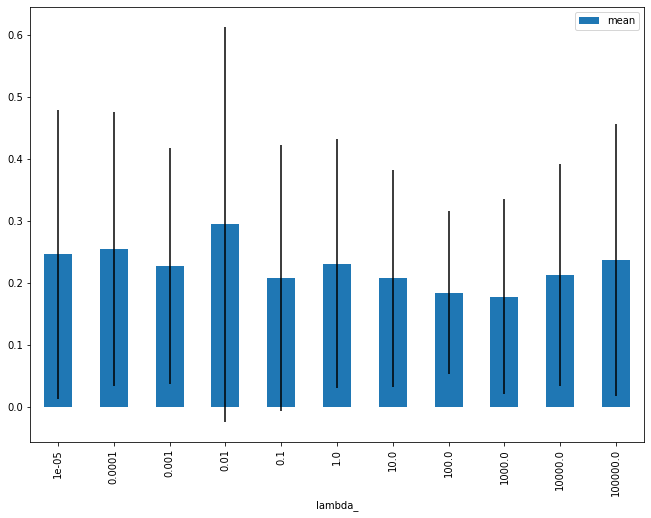

In [77]:
by_lambda.plot.bar(yerr="std", figsize=(11, 8))